# Sentiment Analysis for Movie Reviews

This project is designed to analyze the movie reviews and develop a classifier to determine whether a movie is good or bad. The used dataset includes a large number of movie reviews from the [Rotten Tomatoes](http://www.rottentomatoes.com) which is available in the file "reviews.csv". In addition, the file "movies.dat" contains metadata for ~65,000 different movies.

Rotten Tomatoes is a meta-review website that aggregates movie reviews from a large number of critics. Here's what the page for this year's [Oscar winner](https://www.rottentomatoes.com/m/the_shape_of_water_2017) looks like. The section on "Critic Reviews" at the bottom is the content that has been scraped and put in the reviews.csv file. Each movie is also given a quantitative score on the Tomatometer which is used to classify the movie as either Fresh (good) or Rotten (bad).

This project is composed of four main parts: 

* Exploratory Data Analysis (EDA) 
* Feature extraction using the [Bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) representation approach
* Predictive modeling using the Multinomial Naive Bayes (MNB) algorithm
* Model evaluation and error analysis

Overall observations:

* Since the Naive Bayes classifiers assume that every word affects the prediction independently of other words, it ignores the meaning of the phrases, i.e. combinations of words that might completely change the meaning of the individual words themselves, which is very common in English language. 

* In addition, the Bag-of-words approach ignores the order of the words in a sentence and performs poorly in dealing with the negated phrases. 

To get started, download the files "reviews.csv" and "movies.dat".

In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

---

## Part 1: Descriptive analysis

#### Loading the datasets and dropping rows that have missing data:

In [30]:
reviews = pd.read_csv('reviews.csv')
movies = pd.read_csv("movies.dat", delimiter='\t')
reviews = reviews[~reviews.quote.isnull()]
reviews = reviews[reviews.fresh != 'none']
reviews = reviews[reviews.quote.str.len() > 0]

### 1.1: Basic features of the dataset

In [31]:
print("Number of reviews in the reviews dataset: {}".format(len(reviews)))
print("Number of unique reviews (quotes) in the reviews dataset: {}".format(reviews['quote'].nunique()))
print("Number of unique reviewers (critics) in the reviews dataset: {}".format(reviews['critic'].nunique()))
print("Number of unique movies in the reviews dataset: {}".format(reviews['imdb'].nunique()))
print("Number of unique movies in the movies dataset: {}".format(movies['imdbID'].nunique()))
print("Number of different publications that have reviews in the reviews dataset: {}".format(reviews['publication'].nunique()))

Number of reviews in the reviews dataset: 13419
Number of unique reviews (quotes) in the reviews dataset: 12814
Number of unique reviewers (critics) in the reviews dataset: 540
Number of unique movies in the reviews dataset: 1720
Number of unique movies in the movies dataset: 9423
Number of different publications that have reviews in the reviews dataset: 64


### 1.2 Number of reviews per reviewer

Using the `reviews` dataset, we create a histogram showing the distribution of the number of reviews per reviewer.

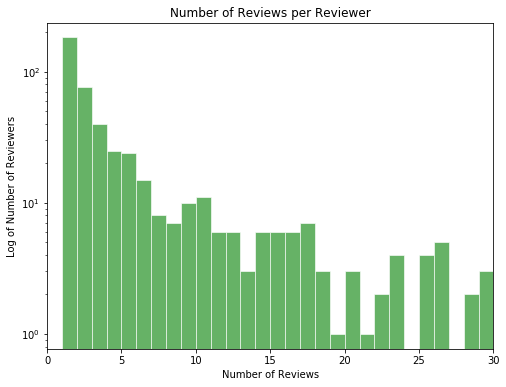

In [32]:
# enter your code here
df1 = pd.DataFrame(reviews.groupby('critic').count())
df1.reset_index(level=0, inplace=True)


plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.hist(df1.quote, range=[0,30], bins=30, facecolor='green', edgecolor='white', alpha=0.6)
plt.xlim([0, 30])
plt.xlabel("Number of Reviews")
plt.ylabel('Log of Number of Reviewers')
plt.yscale('log', nonposy='clip')
plt.title('Number of Reviews per Reviewer')
plt.show()


### 1.3 Zoom in on a few reviewers

The 30 critics with the most reviews are listed along with the name of the publication they work for, the date of their first review, and the date of their last review.

In [33]:
# Create initial dataframe
df2 = pd.DataFrame(reviews.groupby('critic')['critic'].count())
df2.columns = ['count']

# Find dates of first reviews
df2_min = pd.DataFrame(reviews.groupby('critic').min())
df2_min = pd.DataFrame(df2_min.iloc[:,5])
df2_min.columns = ['start_date']
df2_min.reset_index(level=0, inplace =True)

# Find dates of last reviews
df2_max = pd.DataFrame(reviews.groupby('critic').max())
df2_max = pd.DataFrame(df2_max.iloc[:,5])
df2_max.columns = ['end_date']
df2_max.reset_index(level=0, inplace =True)

# Find name of publications 
publications = []
for i in range(len(df2.index)):
    publications.append(reviews[reviews.critic == df2.index[i]]['publication'].unique())
df2.reset_index(level=0, inplace=True)
df2['publication'] = publications

# Merge all info 
dates = pd.merge(df2_min, df2_max, on='critic')
df2 = pd.merge(df2, dates, on='critic')

# Sort and print the final dataframe 
final = df2.sort_values(['count'], ascending=False).head(30)
final.drop('count', 1, inplace = True)
final.index = range(1,31)
pd.set_option('display.max_colwidth', -1)
display(final)


,critic,publication,start_date,end_date
1,Roger Ebert,"[Chicago Sun-Times, At the Movies]",2000-01-01 00:00:00,2013-06-11 00:00:00
2,James Berardinelli,[ReelViews],1800-01-01 00:00:00,2012-02-07 00:00:00
3,Janet Maslin,[New York Times],2000-01-01 00:00:00,2010-09-07 00:00:00
4,Variety Staff,[Variety],2001-02-13 00:00:00,2012-08-15 00:00:00
5,Jonathan Rosenbaum,[Chicago Reader],1988-07-11 00:00:00,2013-10-22 00:00:00
6,Desson Thomson,[Washington Post],2000-01-01 00:00:00,2012-10-08 00:00:00
7,Geoff Andrew,[Time Out],2005-08-11 00:00:00,2012-04-05 00:00:00
8,Dave Kehr,"[Chicago Reader, New York Daily News, Chicago Tribune]",2000-01-01 00:00:00,2013-11-20 00:00:00
9,Kenneth Turan,[Los Angeles Times],2000-01-01 00:00:00,2013-10-05 00:00:00
10,Mick LaSalle,[San Francisco Chronicle],2000-01-01 00:00:00,2009-11-25 00:00:00


### 1.4 Ratings over time

Using the `movies` dataset, we create a scatterplot that shows how the average rating per movie (rtAllCriticsRating) has evolved over time. Movies with 0 or unknown values are dropped to avoid biasing your results. 

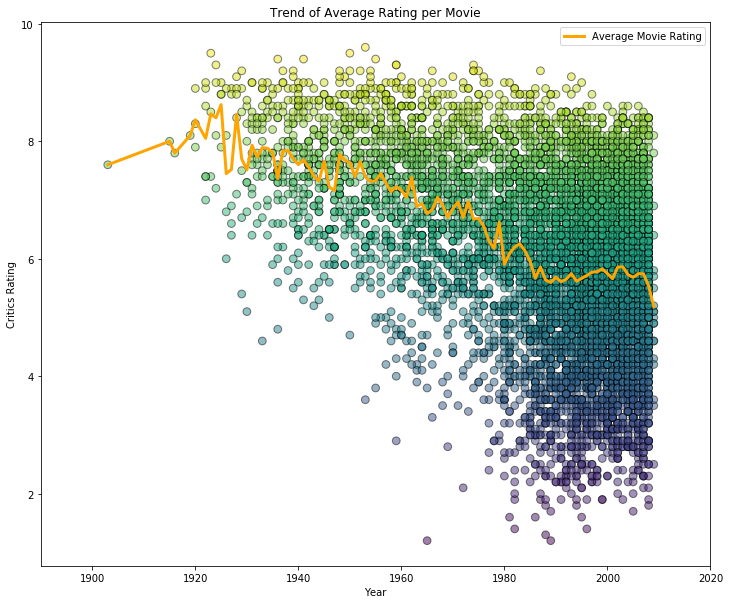

In [39]:
# Drop movies with 0 or unknown values
movies['rtAllCriticsRating'] = movies['rtAllCriticsRating'].apply(pd.to_numeric, errors='coerce')
movies['rtAllCriticsRating'] = movies['rtAllCriticsRating'].apply(lambda x: x if x > 0 else None)

# Plot the scatterplot 
plt.figure(figsize=(12,10))
colors = list(movies['rtAllCriticsRating'].apply(lambda x: x*2))
plt.scatter(movies['year'], movies['rtAllCriticsRating'], c=colors, s=60, alpha = 0.5, edgecolor = 'black')

# Plot the line graph

movies_2 = movies[movies.rtAllCriticsRating != '\\N']
movies_2.loc[:,'rtAllCriticsRating'] = movies_2['rtAllCriticsRating'].astype(float)
movies_2 = movies_2[movies_2.rtAllCriticsRating > 0]
a = movies_2.groupby('year')['rtAllCriticsRating'].mean()
df3 = pd.DataFrame({'year': a.index.tolist(), 'avg_rate': a.tolist()})
plt.plot(df3['year'], df3['avg_rate'], '-', c='orange', linewidth=3.0, label='Average Movie Rating')
plt.xlabel('Year')
plt.ylabel('Critics Rating')
plt.title('Trend of Average Rating per Movie')
plt.xlim([1890, 2020])
plt.legend()
plt.show()


#### Observations: 

In the scatterplot, every point is for a movie whose x-axis value is its release year and y-axis value is the ratings of the critics for that movie. As the color of the points change from blue to green, we observe higher ratings. From the scatterplot, we see that the density of the points increases towards the right end of the x-axis. Hence, we can conclude that the number of ratings increases by the year.* 

In the line graph, although there are some fluctuations, we observe that the overall trend is that the average critics ratings for the movies decrease over the years. This can be explained by the fact that the <ins>average</ins> rating gets lower as the number of reviews increases over the years. Also, by the improvements in technology, the number of movies in any genre increases over the years which might be a cause for the decrease in the quality/uniqueness level of the movies and hence the decrease in the ratings done by the critics.

---

## Part 2: Multinomial Naive Bayes

We use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is Fresh (good) or Rotten (bad), depending on the text of the review. 

### 2.1 Feature Extraction ([Bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) approach)

To convert the raw text fields into "bag of words" vectors, i.e. a data structure that tells you how many times a particular word appears in a blurb, the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object in Scikit-learn is utilized.  

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

Using the `reviews` dataframe, we compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). 
 
Note: Items with no review text are removed.

In [16]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
def make_xy(reviews, vectorizer=None):
    if vectorizer == None:
        vectorizer = CountVectorizer()
    
    quotes_list = list(reviews.quote)
    vectorizer.fit(quotes_list)
    X = vectorizer.transform(quotes_list)
    Y = reviews.fresh.values
    return X.toarray(), Y

In [17]:
X, Y = make_xy(reviews)

### 2.2 Test-Train split

Next, we randomly split the data into two groups: a training set (80%) and a validation set (20%). 

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

print("Training Set:")
print(X_train.shape)
print(Y_train.shape)
print()
print("Test Set:")
print(X_test.shape)
print(Y_test.shape)

Training Set:
(10735, 20875)
(10735,)

Test Set:
(2684, 20875)
(2684,)


### 2.3 Naive Bayes with `MultinomialNB`

We use the geenrated training set to train a Naive Bayes classifier using the [`MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) object. 

In [19]:
# Train the Naive Bayes classifier using the training set
NB = MultinomialNB()
NB.fit(X_train, Y_train)
fitted_model = NB

print("Accuracy of the training set: ", NB.score(X_train, Y_train))
print("Accuracy of the test set: ", NB.score(X_test, Y_test))

Accuracy of the training set:  0.9214718211457849
Accuracy of the test set:  0.7876304023845008


#### Observations: 

Based on the accuracy levels printed above, we see that the Naive Bayes classifier performs almost perfectly on the training set but it performs relatively much lower on the test set. This can be explained by the fact of overfitting the training set which cause a decrease in generalization for the new test instances. 


---

## Part 3: Evaluation

### 3.1 Estimate the likelihood of your data

Given a fitted model, we compute the log-likelihood of the data as a way to assess the performance of your model.  Using `fitted_model.predict_logproba`, the idea is to write a function that computes the log-likelihood of a dataset, so that we can inspect the log-likelihood of your training and testing data given the fitted model from part 2.

In [20]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
model : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""

def log_likelihood(model, x, y):
    prob = model.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

# output the likelihood of your test data (example - you may need to 
# change the names of the variables below to match your code in 2.2 and 2.3
log_likelihood(fitted_model, X_test, Y_test)

-7168.032115268148

### 3.2 Cross-Validation (wrt Log-likelihood)

Our classifier has a few hyperparameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

To cross-validate these tuning hyperparameters, the objective function that we want to maximize is the log-likelihood of the data. 

In [21]:
# the grid of parameters to search over
alphas = [1e-10, 0.1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        
        X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y, test_size = 0.20, random_state = 0)
        NB2 = MultinomialNB(alpha = alpha)
        
        ll = np.mean(cross_val_score(NB2, X_test2, Y_test2, scoring = log_likelihood, cv = 5))
        
        if ll > max_loglike:
            best_alpha = alpha
            best_min_df = min_df
            max_loglike = ll

print("The best alpha value = ", best_alpha)
print("The best min_df value = ", best_min_df)
print("The maximum log-likelihood value = ", max_loglike)

The best alpha value =  10
The best min_df value =  0.1
The maximum log-likelihood value =  -543.3427600846684


### 3.3 Training a final classifier

Using the alpha and min_df that optimize the cross-validated log-likelihood, we repeat the steps in 2.1-2.3 to train a final classifier with these parameters and re-evaluate the accuracy. 

In [22]:
best_vectorizer = CountVectorizer(min_df = best_min_df)
X_best, Y_best = make_xy(reviews, best_vectorizer)

X_train_best, X_test_best, Y_train_best, Y_test_best = train_test_split(X_best, Y_best, test_size = 0.2, random_state = 0)

best_fitted_model = MultinomialNB(alpha = best_alpha)
best_fitted_model.fit(X_train_best, Y_train_best)

print("Accuracy of the training set: ", best_fitted_model.score(X_train_best, Y_train_best))
print("Accuracy of the test set: ", best_fitted_model.score(X_test_best, Y_test_best))

Accuracy of the training set:  0.6271075919888216
Accuracy of the test set:  0.624441132637854


#### Observations: 

Accuracy of the training set from part 2.3:  0.9214718211457849   
Accuracy of the test set from part 2.3:  0.7876304023845008

By performing cross-validation, we aim to obtain a much better estimate of the accuracy of our classifier. According to the estimates obtained as a result of cross-validation, we see that the accuracy for both the training and test sets are reduced compared to the values obtained from part 2.3 (as written above). So, the new model is less accurate but it reduces the overfitting on the training set.

### 3.4 Cross-validation (wrt Classification accuracy)

In [23]:
# the grid of parameters to search over
alphas = [1e-10, 0.1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_score = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(reviews, vectorizer)
        
        X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X, Y, test_size = 0.20, random_state = 0)
        NB3 = MultinomialNB(alpha = alpha)
        
        score = np.mean(cross_val_score(NB3, X_test3, Y_test3, scoring = 'accuracy', cv = 5))
        
        if max_score < score:
            best_alpha = alpha
            best_min_df = min_df
            max_score = score

print("The best alpha value = ", best_alpha)
print("The best min_df value = ", best_min_df)
print("The maximum classification accuracy (score) for test data= ", max_score)
print()

## Putting it together using the best hyperparameter values according to classification accuracy
best_vectorizer = CountVectorizer(min_df = best_min_df)
X_best, Y_best = make_xy(reviews, best_vectorizer)

X_train_best, X_test_best, Y_train_best, Y_test_best = train_test_split(X_best, Y_best, test_size = 0.2, random_state = 0)

best_fitted_model = MultinomialNB(alpha = best_alpha)
best_fitted_model.fit(X_train_best, Y_train_best)

print("Accuracy of the training set: ", best_fitted_model.score(X_train_best, Y_train_best))
print("Accuracy of the test set: ", best_fitted_model.score(X_test_best, Y_test_best))


The best alpha value =  1
The best min_df value =  0.001
The maximum classification accuracy (score) for test data=  0.7194488451596764

Accuracy of the training set:  0.7986027014438751
Accuracy of the test set:  0.7593144560357675


#### Observations: 

In this part, the scoring function is the classification accuracy instead of the log-likelihood. Based on the results printed above, we see that the best alpha value is decreased from 10 to 1 and the best min_df value is decreased from 0.1 to 0.001. By using these values, I repeated the previous part and recalculated the accuracy levels. As printed above, we that the accuracy for both the training and test sets are improved compared to the values obtained from part 3.2. On the other hand, the accuracy for the training set obtained in this part (0.7986027) is much lower than that the accuracy for the training set obtained in part 2.3 (0.92147182). However, the accuracy for the test test obtained in this part (0.75931445) is almost equal to the accuracy for the test test obtained in part 2.3 (0.787630).

From these comparisons, we can conclude that using the classification accuracy as the objective function not only reduces the overfitting effect compared to part 2.3 (where we didn't perform cross-validation) but also increases the generalization or the accuracy for the test data compared to part 3.2 (where the objective function was the log-likelihood). Although the cross-validation performed in part 3.2 has also reduced the overfitting effect, it was worse in terms of generalization/the accuracy for the test data. So, we can conclude that using the classification accuracy as the objective function is better than using the log-likelihood as the objective function.

### 3.5 The most powerful words 

Now, we use our classifier to identify the top 10 words that best predict a Fresh or Rotten review.

In [24]:
# Re-train the classifier using the best parameter values obtained in part 3.4
vectorizer = CountVectorizer(min_df = 0.001, stop_words='english')
X, Y = make_xy(reviews, vectorizer)
fitted_model = MultinomialNB(alpha = 1)
fitted_model.fit(X, Y)

# Create a new dataframe 
df_words = pd.DataFrame(np.array(vectorizer.get_feature_names()), columns = ['words'])
probability = fitted_model.predict_log_proba(np.identity(np.shape(df_words)[0]))
df_words['P_rotten'] = probability[:,1]
df_words['P_fresh'] = probability[:,0]

print ('The 10 words that best predict a "rotten" review:')
print (df_words.sort_values('P_rotten', ascending=False)[['words', 'P_rotten']].head(10))
print ()
print ('The 10 words that best predict a "fresh" review:')
print (df_words.sort_values('P_fresh', ascending=False)[['words', 'P_fresh']].head(10))

The 10 words that best predict a "rotten" review:
               words  P_rotten
943   lame           -0.034466
1273  pointless      -0.035768
1808  unfortunately  -0.042136
1810  uninspired     -0.042136
1437  sadly          -0.054199
1743  tiresome       -0.054199
450   disappointment -0.079117
1809  unfunny        -0.082569
157   bland          -0.087669
1125  muddled        -0.118885

The 10 words that best predict a "fresh" review:
              words   P_fresh
410   delight       -0.024266
884   intimate      -0.038372
218   captures      -0.041379
257   childhood     -0.044898
1132  myth          -0.044898
1426  rousing       -0.046892
1477  seductive     -0.049071
570   expertly      -0.051462
1807  unforgettable -0.051462
99    astonishing   -0.054099


#### Observations: 

The 10 words that best predict a "fresh" review, and the 10 words that best predict a "rotten" review are reported above. Also, for each word, the model's probability of freshness/rottenness (if the word appears one time) is also reported above. The printed words are very intuitive and not surprising because the listed words with a positive meaning (such as delight, unforgettable, astonishing) predict 'fresh' and the listed words with a negative meaning (such as unfortunately, unfunny, disappointment) predict 'rotten' as it should be. Hence, we can conclude that our classifier with the hyperparameter values that maximizes the classification accuracy works well.

### 3.6 Error Analysis

Now, to get an inspiration to improve our model, we look at the examples where our model performs poorly. 

In [27]:
# Add new columns to the reviews dataframe
reviews['prediction'] = fitted_model.predict(X)
reviews['result'] = (reviews.prediction == reviews.fresh)

# Calculate log likelihoods for predictions and add new columns to the reviews dataframe
probability2 = fitted_model.predict_log_proba(X)
reviews['P_rotten'] = probability2[:,1]
reviews['P_fresh'] = probability2[:,0]

# Create a new dataframe for wrong predictions
wrong = pd.DataFrame(reviews[reviews.result == False])

pd.options.display.max_colwidth = 300
print('\033[1m' + "The 5 fresh reviews where our model performs most poorly (that are actually rotten):")
print('\033[0m')
print(wrong.sort_values('P_fresh', ascending = False)['quote'].head(5))

print()
print('*******************************************************************************************************************')
print()

print('\033[1m' + "The 5 rotten reviews where our model performs most poorly (that are actually fresh):")
print('\033[0m')
print(wrong.sort_values('P_rotten', ascending = False)['quote'].head(5))

print()
print('*******************************************************************************************************************')
print()

# Freshness probability for the an review
print("The freshness probability for the review 'This movie is not remarkable, touching, or superb in any way':" + 
      str(fitted_model.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))[0,0]))
                                                                                                                                                             

The 5 fresh reviews where our model performs most poorly (that are actually rotten):

12515                                                        This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.
6048                                           Farley, a real lightweight compared to such late, great predecessors John Belushi and John Candy, brings none of Belushi's edgy intelligence, nor Candy's gentle pathos to this comic caricature.
7707     It is perhaps Spirit's greatest achievement that the horses upstage the human actors, but it's also its greatest weakness. The human characters have no depth or personality, but are rather completely forgettable, stiff stereotypes.
2206                                                                                                               Irons gives an excruciating performance - what Streep's genuinely warm, wond

#### Observations: 

The top 5 mis-predicted reviews are reported above for 'fresh' and 'rotten' movies. These mis-predictions are mostly based on the independence assumption of the Naive Bayes classifiers. For instance, the second review that is predicted as 'fresh' is predicted this way since it includes words such as 'great', 'intelligence', 'gentle' which have positive meanings. However, the classifier doesn't account for the words 'none' and 'nor' which convey an opposite meaning when combined with the positive words. Another example is the first review that is predicted as 'rotten' since it includes words such as 'bad' and 'poor'. However, as can be understand from the question at the end of the review, this review has a positive rating overall considering the typical films of Mel Brooks.

Naive Bayes classifiers assume that every word affects the probability independently of other words. These examples show that the indepence assumption for the messages conveyed by the words in a sentence does not work well for classification purposes since it ignores the meaning of the phrases, i.e. combinations of words that might completely change the meaning of the individual words themselves, which is very common in English language.

The test instance "This movie is not remarkable, touching, or superb in any way" also provides a great example for the inefficiency of the independence assumption of the Naive Bayes classifiers. As reported above, this test instance
is predicted to be 'fresh' review with a chance of 99.936%. However, it should be very clear that this review is a negative review. Since the sentence includes too many positive words such as 'remarkable', 'touching', and 'superb', the classifier gives a much less weight to the word 'not' than the other words. Hence, the classifier fails to predict this instance as 'rotten' since it ignores the overall context of the sentence.